Fitting a power law to the results of the model ladder
===

In [7]:
pile_ce = {
    "baseline-150M-2xC": 2.731,
    "baseline2-150M-2xC": 2.726,
    "baseline-300M-2xC": 2.501,
    "baseline2-150M-5xC": 2.616,
    "baseline-300M-5xC": 2.403,
    "baseline-1B-2xC": 2.198,
    "baseline-300M-1xC": 2.601,
    "baseline-300M-3xC": 2.457,
    "baseline-300M-4xC": 2.425,
    "baseline-750M-2xC": 2.290
}

c4_ce = {
    "baseline-150M-2xC": 3.328,
    "baseline2-150M-2xC": 3.327,
    "baseline-300M-2xC": 3.104,
    "baseline2-150M-5xC": 3.221,
    "baseline-300M-5xC": 3.009,
    "baseline-1B-2xC": 2.791,
    "baseline-300M-1xC": 3.203,
    "baseline-300M-3xC": 3.058,
    "baseline-300M-4xC": 3.028,
    "baseline-750M-2xC": 2.885
}

import re
run_name_re = re.compile(r"^([^-]+)-([^-]+)-([^-]+)$")

import ladder
def parse_run_name(name: str):
    name, size, length = run_name_re.match(name).groups()
    size = ladder.parse_size(size)
    length = ladder.parse_length(length, size)
    return name, size, length
    

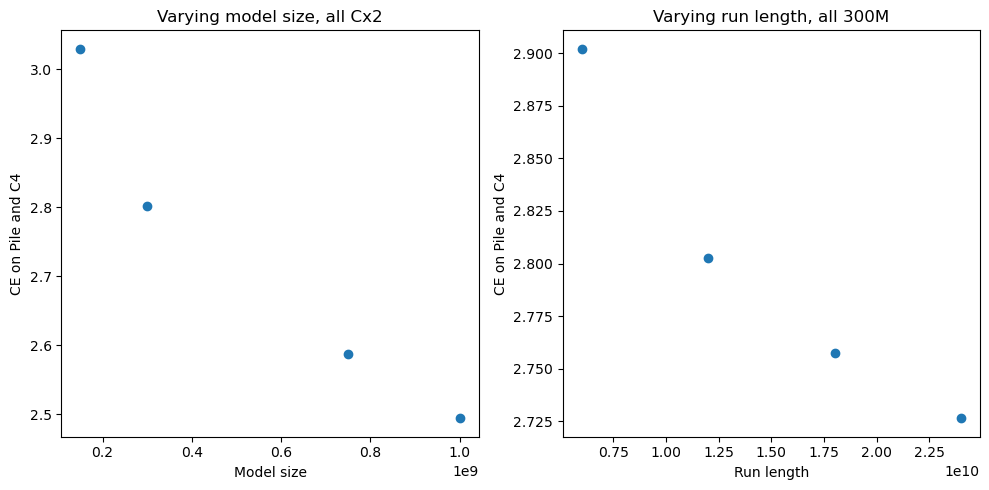

In [9]:
import matplotlib.pyplot as plt

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# make model size plot
x = []
y = []
for run in ["baseline-150M-2xC", "baseline-300M-2xC", "baseline-750M-2xC", "baseline-1B-2xC"]:
    name, size, length = parse_run_name(run)
    x.append(size)
    y.append((pile_ce[run] + c4_ce[run])/2)
ax1.scatter(x, y)
ax1.set_title("Varying model size, all Cx2")
ax1.set_xlabel("Model size")
ax1.set_ylabel("CE on Pile and C4")

# make length plot
x = []
y = []
for run in ["baseline-300M-1xC", "baseline-300M-2xC", "baseline-300M-3xC", "baseline-300M-4xC"]:
    name, size, length = parse_run_name(run)
    x.append(length)
    y.append((pile_ce[run] + c4_ce[run])/2)
ax2.scatter(x, y)
ax2.set_title("Varying run length, all 300M")
ax2.set_xlabel("Run length in tokens")
ax2.set_ylabel("CE on Pile and C4")

# show
plt.tight_layout()
plt.show()

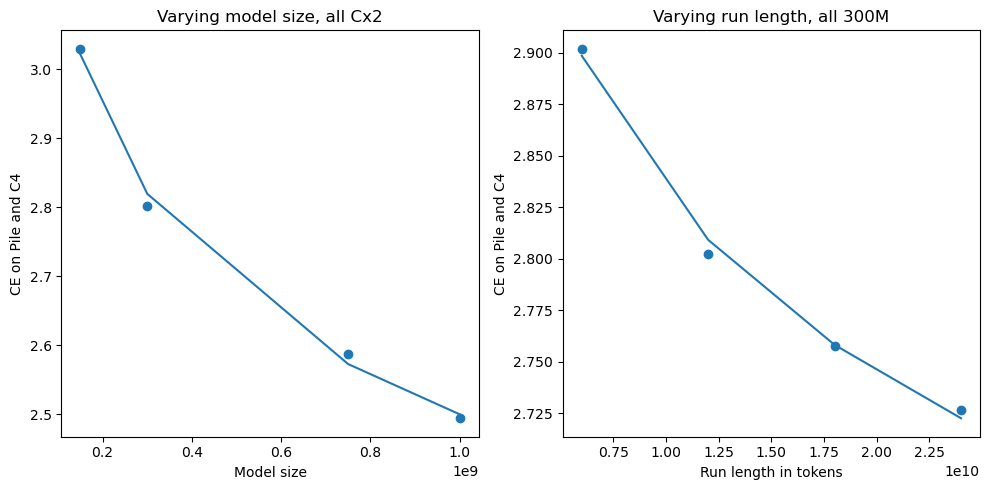

In [18]:
def power_law(x, a, b):
    return a * x ** b

from scipy.optimize import curve_fit
import numpy as np

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# model size
x = []
y = []
for run in ["baseline-150M-2xC", "baseline-300M-2xC", "baseline-750M-2xC", "baseline-1B-2xC"]:
    name, size, length = parse_run_name(run)
    x.append(size)
    y.append((pile_ce[run] + c4_ce[run])/2)

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, x, y)
ax1.scatter(x, y)
ax1.set_title("Varying model size, all Cx2")
ax1.set_xlabel("Model size")
ax1.set_ylabel("CE on Pile and C4")
ax1.plot(x, power_law(x, *popt))

# run length
x = []
y = []
for run in ["baseline-300M-1xC", "baseline-300M-2xC", "baseline-300M-3xC", "baseline-300M-4xC"]:
    name, size, length = parse_run_name(run)
    x.append(length)
    y.append((pile_ce[run] + c4_ce[run])/2)

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, x, y)
ax2.scatter(x, y)
ax2.set_title("Varying run length, all 300M")
ax2.set_xlabel("Run length in tokens")
ax2.set_ylabel("CE on Pile and C4")
ax2.plot(x, power_law(x, *popt))

plt.tight_layout()
plt.show()